In [1]:
import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np

2.9.1


In [2]:
#change this line:
work_dir = "/Users/gohyixian/Downloads"

In [3]:
val_dir = work_dir + "/NLP-Depression/Dataset/validation_data.csv"
val_all = pd.read_csv(val_dir, index_col=False, encoding="utf-8")
val_all.head()

,text_join,class
0,kim beautiful sisters cute childen,0
1,shut going rasict hear another thing,1
2,like mario galaxy probably like video httpsyou...,1
3,great workout thanks much,0
4,walking forest see two sticks one large one sm...,1


In [4]:
from sklearn.model_selection import train_test_split

x_val = val_all["text_join"]
y_val = val_all["class"]

# some data type compatibility formatting
x_val = np.asarray(x_val.to_frame().to_numpy(dtype=np.string_)).astype(np.string_)
y_val = np.asarray(y_val.to_frame().to_numpy(dtype=np.string_)).astype(np.string_)


# convert y data to labels of [0,1,0]
# one-hot encoding
def createLabels(y):
    counter = 0
    result = np.array([])
    # initialize np.array based on first Training Example
    if y[0] == np.string_("0"):
        result = np.array([0])
    elif y[0] == np.string_("1"):
        result = np.array([1])
    elif y[0] == np.string_("2"):
        result = np.array([2])
    # skip the first, process the other training examples
    for i in y:
        if counter > 0:
            if i == np.string_("0"):
                result = np.append(result, np.array([0]), axis=0)
            elif i == np.string_("1"):
                result = np.append(result, np.array([1]), axis=0)
            elif i == np.string_("2"):
                result = np.append(result, np.array([2]), axis=0)
        counter+=1
    return result

def createLabelsForAUROC(y):
    counter = 0
    result = np.array([[]])
    # initialize np.array based on first Training Example
    if y[0] == np.string_("0"):
        result = np.array([[1,0,0]])
    elif y[0] == np.string_("1"):
        result = np.array([[0,1,0]])
    elif y[0] == np.string_("2"):
        result = np.array([[0,0,1]])
    # skip the first, process the other training examples
    for i in y:
        if counter > 0:
            if i == np.string_("0"):
                result = np.append(result, np.array([[1,0,0]]), axis=0)
            elif i == np.string_("1"):
                result = np.append(result, np.array([[0,1,0]]), axis=0)
            elif i == np.string_("2"):
                result = np.append(result, np.array([[0,0,1]]), axis=0)
        counter+=1
    return result


y_val_roc = createLabelsForAUROC(y_val)
y_val2 = createLabels(y_val)


print(x_val.shape)
print(y_val2.shape)
print(y_val2)
print(y_val_roc.shape)
print(y_val_roc)

(28520, 1)
(28520,)
[0 1 1 ... 1 1 1]
(28520, 3)
[[1 0 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


# Model Reloading

In [5]:
from tensorflow.keras.models import load_model

model_dir = work_dir + "/NLP-Depression/Model/Hot_Stuff"
model = load_model(model_dir)

print("Loaded")

Loaded


In [6]:
y_pred = model.predict(x_val)

892/892 [==============================] - 287s 320ms/step


In [17]:
def predToLogits(y):
    counter = 0
    result = np.array([])
    # initialize np.array based on first Training Example
    if y[0][0] == y[0].max():
        result = np.array([0])
    elif y[0][1] == y[0].max():
        result = np.array([1])
    elif y[0][2] == y[0].max():
        result = np.array([2])
    # skip the first, process the other training examples
    for i in range(int(y.size/3)):
        if counter > 0:
            if y[i][0] == y[i].max():
                result = np.append(result, np.array([0]), axis=0)
            elif y[i][1] == y[i].max():
                result = np.append(result, np.array([1]), axis=0)
            elif y[i][2] == y[i].max():
                result = np.append(result, np.array([2]), axis=0)
        counter+=1
    return result
 

y_pred_logits = predToLogits(y_pred)

<h2>Precision, Recall, F1-Score</h2>

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_val2, y_pred_logits, target_names=["Normal 0", "Depressed 1", "Suicidal 2"]))

              precision    recall  f1-score   support

    Normal 0       0.94      0.94      0.94     16904
 Depressed 1       0.76      0.80      0.78      5737
  Suicidal 2       0.93      0.89      0.91      5879

    accuracy                           0.90     28520
   macro avg       0.88      0.88      0.88     28520
weighted avg       0.90      0.90      0.90     28520



<h2>AUROC</h2>

Known as AUROC (Area Under the Receiver Operating Characteristic Curve) or ROC AUC. The higher the AUROC score, the higher greater the distinction between classes

In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val_roc, y_pred, average="weighted", multi_class="ovr")

0.9749955341729309

<h2>Cohen's Kappa Score</h2>

A supercharged version of accuracy, a version that also integrates measurements of chance and class imbalance. Generally, a score above 0.8 is considered excellent.

In [21]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_val2, y_pred_logits)

0.8244935530130881

<h2>Matthew's Correlation Coefficient</h2>

1.0 means a perfect classifier, while a value close to 0.0 means that the classifier is no better than a random chance. Generally, scores over 0.7 are considered good, a strong correlation.

In [22]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_val2, y_pred_logits)

0.8246430928123034

<h2>TensorBoard Visualisation</h2>

In [2]:
# Visualize Metrics using the TensorBoard Magic 🧚🏻
# Remember to screenshot tho..

#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir Logs --load_fast=false

The cell below is a screenshot of the most recent tensorboard for ease of reference.

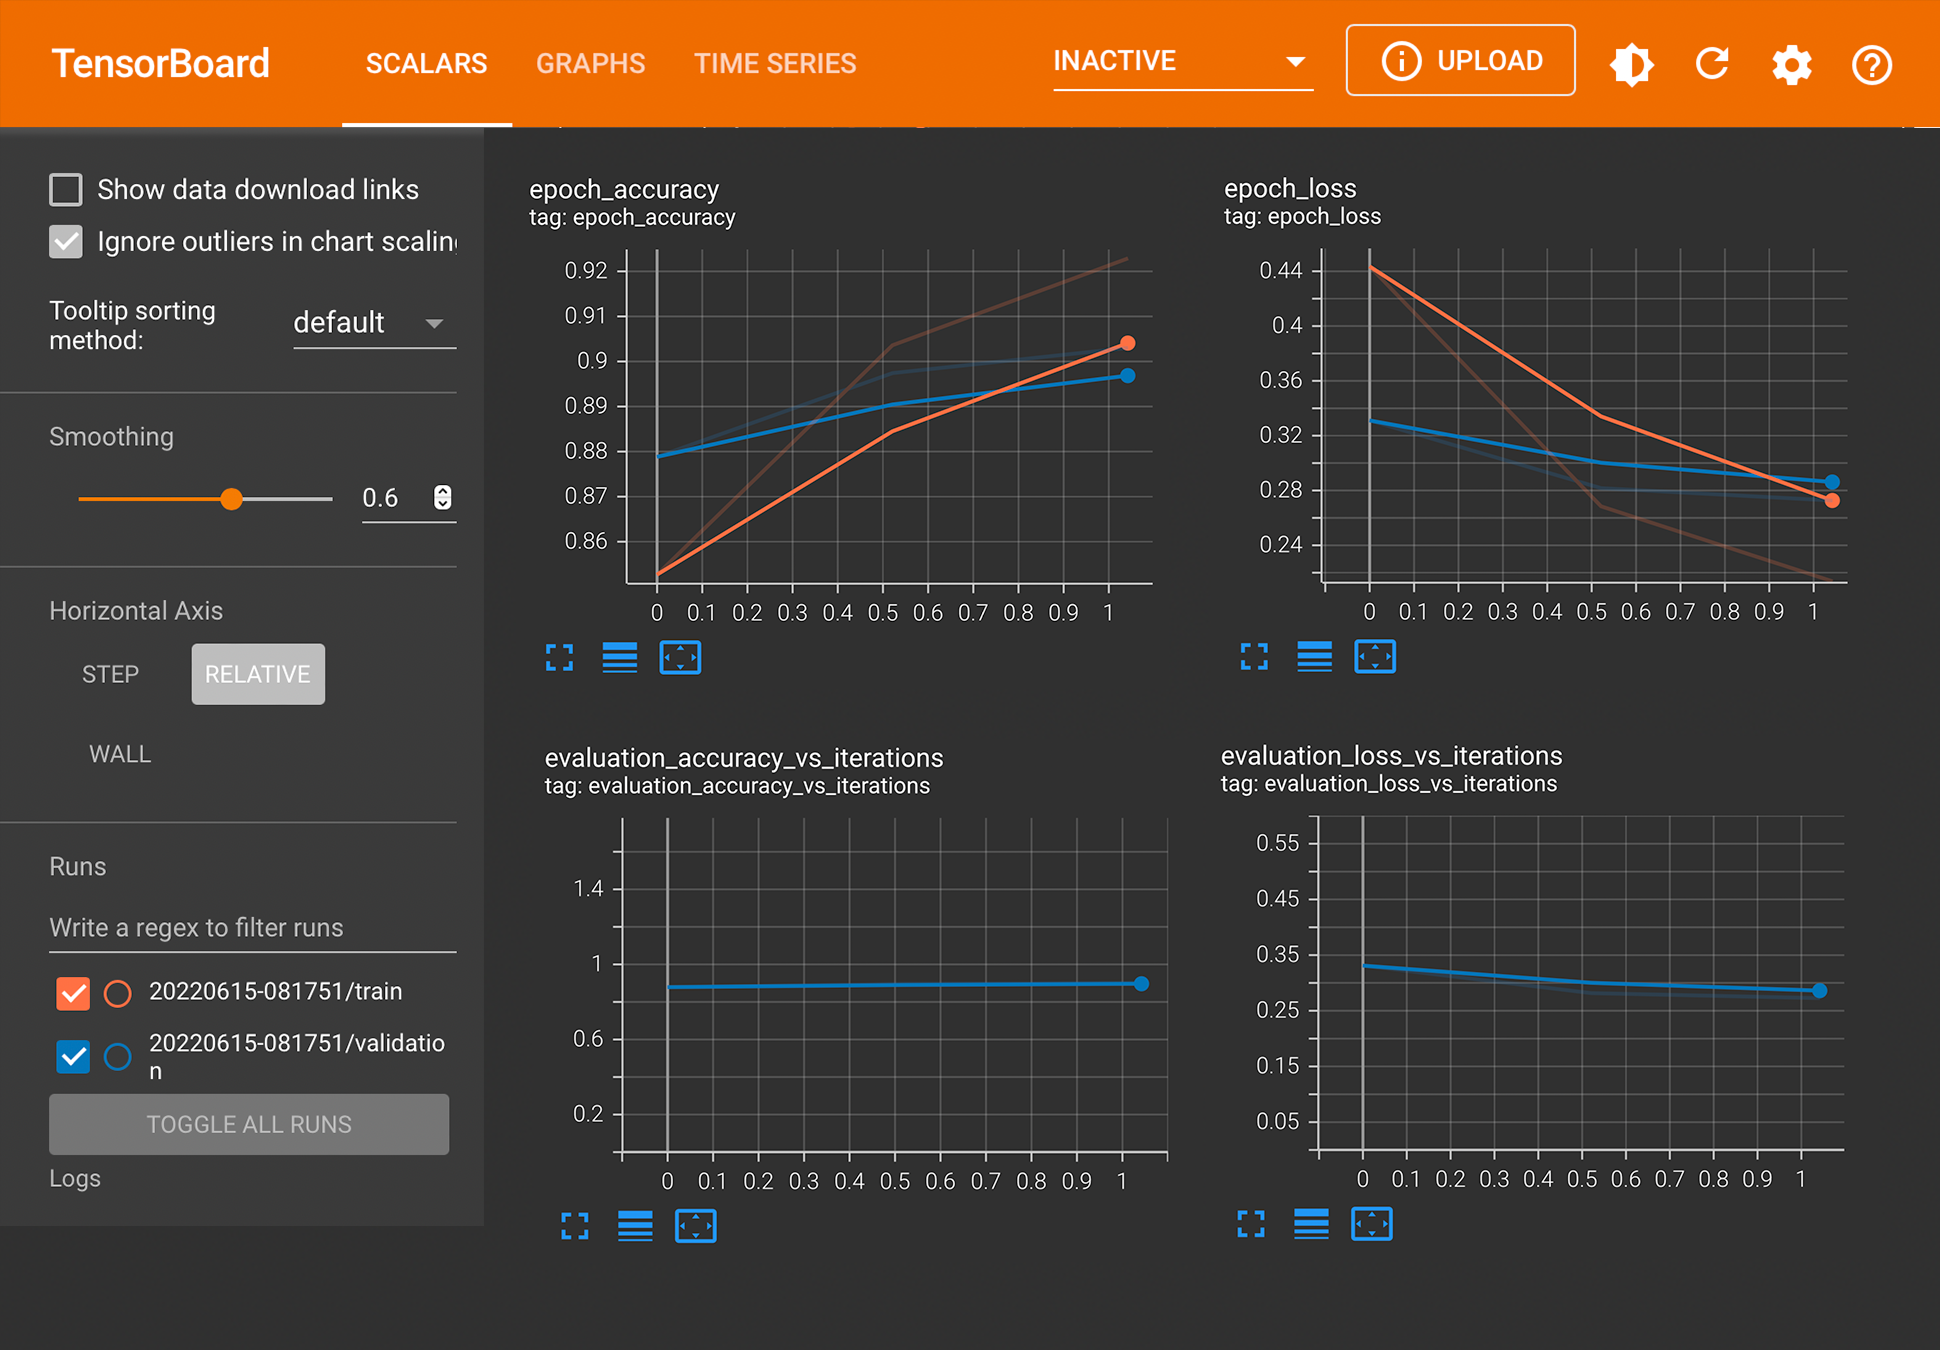

# Model Testing

In [ ]:
import contractions
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

stopwords = set(stopwords.words('english'))


def predict(model, input, stopwords=stopwords):
    
    # cleaning input data
    input = input.lower()
    input = input.split(" ")
    input = [re.sub(r"[^\w\d\s\']+", "", x) for x in input]
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)
    
    input = [re.sub(emoj, "", x) for x in input]
    input = [x.encode("ascii", "ignore").decode() for x in input]
    input = [x for x in input if x != ""]
    input = [contractions.fix(x) for x in input]
    input = ' '.join(map(str, input))
    input = word_tokenize(input, language="english")
    input = [x for x in input if x not in stopwords]
    input = [x for x in input if not x.isdigit()]
    input = ' '.join(map(str, input))
    filtered_text = input

    x_input = np.array([input], dtype=np.string_)
    y = model.predict(x_input)
    result = ""
    if y[0][0] == y[0].max():
        result = "No Depression"
    elif y[0][1] == y[0].max():
        result = "Depression Detected"
    elif y[0][2] == y[0].max():
        result = "Suicidal Depression"
        
    return (result, y, filtered_text)

In [ ]:
while True:
    x = input("Enter Text: ")
    if x == "exit":
        break
    y = predict(model, x)
    print("Filtered Text : " + y[2])
    print("Model Result  : " + y[0])
    print("No Depression       :", y[1][0][0])
    print("Depression Detected :", y[1][0][1])
    print("Suicidal Depression :", y[1][0][2])
    print("")
    print("---------------------------------------------------")

print("Completed")